In [67]:
pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Working with baseline features folder

In [68]:
import pandas as pd
import os

# 1. First, let's properly read one sample file to understand the structure
sample_file = os.path.join("baseline_features", os.listdir("baseline_features")[0])
with open(sample_file) as f:
    first_line = f.readline().strip()  # Get header
    second_line = f.readline().strip()  # Get first data row

print("Header line:", first_line)
print("First data line:", second_line)

# 2. Parse the header correctly
feature_names = first_line.split(';')
print(f"\nFound {len(feature_names)} features in header")

# 3. Reload all files with proper column names
dfs = []
for file in os.listdir("baseline_features"):
    if file.endswith('.csv'):
        filepath = os.path.join("baseline_features", file)
        
        # Read with correct separator and header
        df = pd.read_csv(filepath, sep=';', header=None)
        
        # Set proper column names from first row
        df.columns = df.iloc[0]  # Use first row as header
        df = df[1:]  # Remove the header row from data
        
        # Add metadata from filename
        parts = file.split('_')
        df['speaker'] = parts[0]
        df['emotion'] = parts[2]
        df['filename'] = file
        
        dfs.append(df)

# 4. Combine all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# 5. Clean up (drop the 'name' column if it exists)
if 'name' in combined_df.columns:
    combined_df = combined_df.drop(columns=['name'])

# 6. Verify
print("\nFinal DataFrame structure:")
print("Columns:", combined_df.columns.tolist()[:10], "...")  # First 10 columns
print("Shape:", combined_df.shape)
print("\nSample data:")
print(combined_df.iloc[:3, :5])  # First 3 rows, first 5 columns

Header line: name;frameTime;pcm_RMSenergy_sma_max;pcm_RMSenergy_sma_min;pcm_RMSenergy_sma_range;pcm_RMSenergy_sma_maxPos;pcm_RMSenergy_sma_minPos;pcm_RMSenergy_sma_amean;pcm_RMSenergy_sma_linregc1;pcm_RMSenergy_sma_linregc2;pcm_RMSenergy_sma_linregerrQ;pcm_RMSenergy_sma_stddev;pcm_RMSenergy_sma_skewness;pcm_RMSenergy_sma_kurtosis;pcm_fftMag_mfcc_sma[1]_max;pcm_fftMag_mfcc_sma[1]_min;pcm_fftMag_mfcc_sma[1]_range;pcm_fftMag_mfcc_sma[1]_maxPos;pcm_fftMag_mfcc_sma[1]_minPos;pcm_fftMag_mfcc_sma[1]_amean;pcm_fftMag_mfcc_sma[1]_linregc1;pcm_fftMag_mfcc_sma[1]_linregc2;pcm_fftMag_mfcc_sma[1]_linregerrQ;pcm_fftMag_mfcc_sma[1]_stddev;pcm_fftMag_mfcc_sma[1]_skewness;pcm_fftMag_mfcc_sma[1]_kurtosis;pcm_fftMag_mfcc_sma[2]_max;pcm_fftMag_mfcc_sma[2]_min;pcm_fftMag_mfcc_sma[2]_range;pcm_fftMag_mfcc_sma[2]_maxPos;pcm_fftMag_mfcc_sma[2]_minPos;pcm_fftMag_mfcc_sma[2]_amean;pcm_fftMag_mfcc_sma[2]_linregc1;pcm_fftMag_mfcc_sma[2]_linregc2;pcm_fftMag_mfcc_sma[2]_linregerrQ;pcm_fftMag_mfcc_sma[2]_stddev;pcm_

In [69]:
print("Columns:", combined_df.columns.tolist()[:5] + ["..."] + combined_df.columns.tolist()[-3:])
print("Speakers:", combined_df['speaker'].unique())
print("Emotions:", combined_df['emotion'].unique())

Columns: ['frameTime', 'pcm_RMSenergy_sma_max', 'pcm_RMSenergy_sma_min', 'pcm_RMSenergy_sma_range', 'pcm_RMSenergy_sma_maxPos', '...', 'speaker', 'emotion', 'filename']
Speakers: ['mm' 'cc' 'mf' 'cl' 'mk' 'jg' 'gg']
Emotions: ['happy' 'panic' 'contempt' 'interest' 'hot-anger' 'boredom' 'pride'
 'despair' 'shame' 'neutral' 'sadness' 'disgust' 'cold-anger' 'elation'
 'anxiety']


In [70]:
from sklearn.preprocessing import StandardScaler

# Separate features from metadata
feature_cols = [col for col in combined_df.columns if col not in ['speaker', 'emotion', 'filename']]

# Z-score normalization per speaker
for speaker in combined_df['speaker'].unique():
    speaker_mask = combined_df['speaker'] == speaker
    scaler = StandardScaler()
    combined_df.loc[speaker_mask, feature_cols] = scaler.fit_transform(combined_df.loc[speaker_mask, feature_cols])

In [71]:
import warnings
warnings.filterwarnings('ignore')

SVM-RBF and LR

In [75]:
pip install xgboost


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [76]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

models = {
    "SVM-RBF": SVC(kernel='rbf', class_weight='balanced', probability=True),
    # "XGBoost": XGBClassifier(tree_method='hist', enable_categorical=True),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    # "MLP": MLPClassifier(hidden_layer_sizes=(128, 64), early_stopping=True)
}

for name, model in models.items():
    print(f"\n=== Evaluating {name} ===")
    speaker_results = []
    
    for test_speaker in combined_df['speaker'].unique():
        # Train-test split
        X_train = combined_df[combined_df['speaker'] != test_speaker][feature_cols]
        X_test = combined_df[combined_df['speaker'] == test_speaker][feature_cols]
        y_train = combined_df[combined_df['speaker'] != test_speaker]['emotion']
        y_test = combined_df[combined_df['speaker'] == test_speaker]['emotion']
        
        # Train and evaluate
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
        speaker_results.append(f1)
    
    avg_f1 = np.mean(speaker_results)
    print(f"{name} Average Weighted F1: {avg_f1:.4f}")


=== Evaluating SVM-RBF ===
SVM-RBF Average Weighted F1: 0.2467

=== Evaluating Logistic Regression ===
Logistic Regression Average Weighted F1: 0.2351


In [77]:
print("Data types:\n", combined_df[feature_cols].dtypes)
print("\nNon-numeric columns:", combined_df[feature_cols].select_dtypes(exclude=['number']).columns.tolist())

Data types:
 0
frameTime                   object
pcm_RMSenergy_sma_max       object
pcm_RMSenergy_sma_min       object
pcm_RMSenergy_sma_range     object
pcm_RMSenergy_sma_maxPos    object
                             ...  
F0_sma_de_linregc2          object
F0_sma_de_linregerrQ        object
F0_sma_de_stddev            object
F0_sma_de_skewness          object
F0_sma_de_kurtosis          object
Length: 385, dtype: object

Non-numeric columns: ['frameTime', 'pcm_RMSenergy_sma_max', 'pcm_RMSenergy_sma_min', 'pcm_RMSenergy_sma_range', 'pcm_RMSenergy_sma_maxPos', 'pcm_RMSenergy_sma_minPos', 'pcm_RMSenergy_sma_amean', 'pcm_RMSenergy_sma_linregc1', 'pcm_RMSenergy_sma_linregc2', 'pcm_RMSenergy_sma_linregerrQ', 'pcm_RMSenergy_sma_stddev', 'pcm_RMSenergy_sma_skewness', 'pcm_RMSenergy_sma_kurtosis', 'pcm_fftMag_mfcc_sma[1]_max', 'pcm_fftMag_mfcc_sma[1]_min', 'pcm_fftMag_mfcc_sma[1]_range', 'pcm_fftMag_mfcc_sma[1]_maxPos', 'pcm_fftMag_mfcc_sma[1]_minPos', 'pcm_fftMag_mfcc_sma[1]_amean', 'pcm_ff

In [78]:
# Convert all features to numeric, coercing errors to NaN
combined_df[feature_cols] = combined_df[feature_cols].apply(pd.to_numeric, errors='coerce')

# Check remaining NaN values
print("NaN counts:\n", combined_df[feature_cols].isna().sum().sort_values(ascending=False).head(10))

NaN counts:
 0
frameTime                               0
pcm_RMSenergy_sma_de_max                0
pcm_fftMag_mfcc_sma_de[5]_skewness      0
pcm_fftMag_mfcc_sma_de[5]_stddev        0
pcm_fftMag_mfcc_sma_de[5]_linregerrQ    0
pcm_fftMag_mfcc_sma_de[5]_linregc2      0
pcm_fftMag_mfcc_sma_de[5]_linregc1      0
pcm_fftMag_mfcc_sma_de[5]_amean         0
pcm_fftMag_mfcc_sma_de[5]_minPos        0
pcm_fftMag_mfcc_sma_de[5]_maxPos        0
dtype: int64


In [79]:
# Option A: Drop columns with >20% NaN
combined_df = combined_df.dropna(thresh=len(combined_df)*0.8, axis=1)

# Option B: Impute median values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
combined_df[feature_cols] = imputer.fit_transform(combined_df[feature_cols])

In [80]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode labels
le = LabelEncoder()
y = le.fit_transform(combined_df['emotion'])

# Scale features (critical for MLP)
scaler = StandardScaler()
X = scaler.fit_transform(combined_df[feature_cols])

# Verify final inputs
print("X dtype:", X.dtype)
print("X contains NaN:", np.isnan(X).any())
print("y shape:", y.shape)

X dtype: float64
X contains NaN: False
y shape: (2324,)


SVM

Improving accuracy

Hyperparameter tuning

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define pipeline (scaling + SVM)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(class_weight='balanced', random_state=42))
])

# Parameter grid
param_grid = {
    'svm__C': [0.1, 1, 10, 100],               # Regularization strength
    'svm__gamma': ['scale', 'auto', 0.01, 0.1], # Kernel bandwidth
    'svm__kernel': ['rbf', 'linear', 'poly']     # Kernel type
}

# Custom leave-one-speaker-out splitter
def speaker_split(X, y, speakers):
    for speaker in np.unique(speakers):
        test_mask = speakers == speaker
        train_mask = ~test_mask
        yield train_mask, test_mask

# Run grid search
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=speaker_split(X, y, combined_df['speaker']),  # Maintain speaker independence
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Fitting 7 folds for each of 48 candidates, totalling 336 fits
[CV 1/7] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear;, score=0.166 total time=   3.4s
[CV 3/7] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.136 total time=   5.3s
[CV 2/7] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.163 total time=   5.3s
[CV 6/7] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.171 total time=   5.4s
[CV 7/7] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.136 total time=   5.6s
[CV 5/7] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.117 total time=   5.7s
[CV 1/7] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.174 total time=   5.8s
[CV 4/7] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.121 total time=   5.8s
[CV 2/7] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear;, score=0.266 total time=   3.3s
[CV 4/7] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear;, score=0.161 total time=   2.9s
[CV 5/7] 

Feature selection

In [86]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)  # Keep features with variance > 0.1
X_high_var = selector.fit_transform(X)
print(f"Reduced from {X.shape[1]} to {X_high_var.shape[1]} features")

Reduced from 385 to 383 features


In [87]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=100)  # Keep top 100 features
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = np.array(feature_cols)[selector.get_support()]
print("Top 10 features:", selected_features[:10])

Top 10 features: ['pcm_RMSenergy_sma_max' 'pcm_RMSenergy_sma_range'
 'pcm_RMSenergy_sma_amean' 'pcm_RMSenergy_sma_linregc2'
 'pcm_RMSenergy_sma_stddev' 'pcm_RMSenergy_sma_skewness'
 'pcm_fftMag_mfcc_sma[1]_max' 'pcm_fftMag_mfcc_sma[1]_range'
 'pcm_fftMag_mfcc_sma[1]_amean' 'pcm_fftMag_mfcc_sma[1]_linregc2']


In [96]:
# After feature selection
svm_tuned = SVC(
    kernel='rbf',
    C=10,                  # From GridSearchCV
    gamma='auto',            # From GridSearchCV
    class_weight='balanced'
)
svm_tuned.fit(X_high_var, y)    # X_new from SelectKBest

SVC(C=10, class_weight='balanced', gamma='auto')

In [97]:
from sklearn.metrics import accuracy_score, classification_report

# Initialize results storage
speaker_accuracies = []
class_reports = []

# Get unique speakers
speakers = combined_df['speaker'].unique()

for test_speaker in speakers:
    # Split data
    test_mask = combined_df['speaker'] == test_speaker
    train_mask = ~test_mask
    
    X_train, X_test = X_high_var[train_mask], X_high_var[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    
    # Train and predict
    svm_tuned.fit(X_train, y_train)
    y_pred = svm_tuned.predict(X_test)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    speaker_accuracies.append(acc)
    
    # Store detailed report
    report = classification_report(
        y_test, y_pred, 
        target_names=le.classes_, 
        output_dict=True
    )
    class_reports.append(report)
    
    # Print per-speaker results
    print(f"Speaker {test_speaker}: Accuracy = {acc:.3f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print("--------------------------------------")

# Aggregate results
mean_accuracy = np.mean(speaker_accuracies)
print(f"\n=== Final Mean Accuracy: {mean_accuracy:.3f} ===")

Speaker mm: Accuracy = 0.318
              precision    recall  f1-score   support

     anxiety       0.60      0.31      0.41        39
     boredom       0.46      0.32      0.38        19
  cold-anger       0.10      0.10      0.10        20
    contempt       0.30      0.32      0.31        19
     despair       0.31      0.50      0.38        18
     disgust       0.24      0.26      0.25        23
     elation       0.21      0.37      0.26        19
       happy       0.44      0.78      0.56        18
   hot-anger       0.46      0.38      0.41        16
    interest       0.17      0.24      0.20        21
     neutral       1.00      0.11      0.20         9
       panic       0.57      0.14      0.23        28
       pride       0.33      0.32      0.32        19
     sadness       0.16      0.18      0.17        17
       shame       0.43      0.53      0.47        17

    accuracy                           0.32       302
   macro avg       0.38      0.32      0.31       3

In [98]:
# Calculate weighted accuracy across all speakers
total_samples = sum([rep['weighted avg']['support'] for rep in class_reports])
weighted_accuracy = sum(
    rep['accuracy'] * rep['weighted avg']['support'] 
    for rep in class_reports
) / total_samples

print(f"\n=== Weighted Accuracy: {weighted_accuracy:.3f} ===")


=== Weighted Accuracy: 0.259 ===


In [99]:
import pandas as pd

# Aggregate class-level metrics
class_stats = []
for emotion in le.classes_:
    precisions = [rep[emotion]['precision'] for rep in class_reports if emotion in rep]
    recalls = [rep[emotion]['recall'] for rep in class_reports if emotion in rep]
    f1s = [rep[emotion]['f1-score'] for rep in class_reports if emotion in rep]
    
    if precisions:  # Skip emotions not evaluated in all folds
        class_stats.append({
            'emotion': emotion,
            'avg_precision': np.mean(precisions),
            'avg_recall': np.mean(recalls),
            'avg_f1': np.mean(f1s),
            'eval_count': len(precisions)
        })

# Create performance summary
performance_df = pd.DataFrame(class_stats).sort_values('avg_f1', ascending=False)
print("\n=== Class-Wise Performance ===")
print(performance_df[['emotion', 'avg_f1', 'avg_precision', 'avg_recall']])


=== Class-Wise Performance ===
       emotion    avg_f1  avg_precision  avg_recall
8    hot-anger  0.394980       0.399544    0.400542
11       panic  0.376636       0.465497    0.342215
10     neutral  0.341497       0.620284    0.299206
1      boredom  0.280302       0.273243    0.300423
3     contempt  0.275924       0.299581    0.277408
14       shame  0.274234       0.276945    0.278071
7        happy  0.250003       0.240766    0.284433
9     interest  0.241758       0.233610    0.255799
6      elation  0.235514       0.200165    0.291364
0      anxiety  0.233491       0.246719    0.238867
2   cold-anger  0.218783       0.218325    0.243233
5      disgust  0.190399       0.235479    0.313036
4      despair  0.181940       0.174680    0.220225
12       pride  0.155535       0.180769    0.147615
13     sadness  0.151300       0.158190    0.147029


In [88]:
from sklearn.feature_selection import RFE

rfe = RFE(
    estimator=SVC(kernel='linear', class_weight='balanced'),
    n_features_to_select=50,  # Keep top 50 features
    step=10                  # Number of features to remove per iteration
)
X_rfe = rfe.fit_transform(X, y)
print("Selected features:", np.array(feature_cols)[rfe.support_])

Selected features: ['pcm_RMSenergy_sma_min' 'pcm_RMSenergy_sma_linregc1'
 'pcm_RMSenergy_sma_skewness' 'pcm_fftMag_mfcc_sma[1]_max'
 'pcm_fftMag_mfcc_sma[1]_amean' 'pcm_fftMag_mfcc_sma[1]_linregc2'
 'pcm_fftMag_mfcc_sma[1]_linregerrQ' 'pcm_fftMag_mfcc_sma[1]_stddev'
 'pcm_fftMag_mfcc_sma[2]_min' 'pcm_fftMag_mfcc_sma[2]_amean'
 'pcm_fftMag_mfcc_sma[2]_stddev' 'pcm_fftMag_mfcc_sma[3]_min'
 'pcm_fftMag_mfcc_sma[4]_amean' 'pcm_fftMag_mfcc_sma[5]_amean'
 'pcm_fftMag_mfcc_sma[6]_amean' 'pcm_fftMag_mfcc_sma[7]_min'
 'pcm_fftMag_mfcc_sma[7]_amean' 'pcm_fftMag_mfcc_sma[7]_linregerrQ'
 'pcm_fftMag_mfcc_sma[7]_stddev' 'pcm_fftMag_mfcc_sma[8]_amean'
 'pcm_fftMag_mfcc_sma[8]_linregc2' 'pcm_fftMag_mfcc_sma[9]_range'
 'pcm_fftMag_mfcc_sma[9]_amean' 'pcm_fftMag_mfcc_sma[9]_linregerrQ'
 'pcm_fftMag_mfcc_sma[10]_min' 'pcm_fftMag_mfcc_sma[10]_amean'
 'pcm_fftMag_mfcc_sma[11]_amean' 'pcm_fftMag_mfcc_sma[12]_amean'
 'pcm_zcr_sma_max' 'pcm_zcr_sma_linregerrQ' 'pcm_zcr_sma_kurtosis'
 'voiceProb_sma_linregc2'

In [100]:
# After feature selection
svm_tuned = SVC(
    kernel='rbf',
    C=10,                  # From GridSearchCV
    gamma='auto',            # From GridSearchCV
    class_weight='balanced'
)
svm_tuned.fit(X_rfe, y)    # X_new from SelectKBest

SVC(C=10, class_weight='balanced', gamma='auto')

In [101]:
from sklearn.metrics import accuracy_score, classification_report

# Initialize results storage
speaker_accuracies = []
class_reports = []

# Get unique speakers
speakers = combined_df['speaker'].unique()

for test_speaker in speakers:
    # Split data
    test_mask = combined_df['speaker'] == test_speaker
    train_mask = ~test_mask
    
    X_train, X_test = X_rfe[train_mask], X_rfe[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    
    # Train and predict
    svm_tuned.fit(X_train, y_train)
    y_pred = svm_tuned.predict(X_test)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    speaker_accuracies.append(acc)
    
    # Store detailed report
    report = classification_report(
        y_test, y_pred, 
        target_names=le.classes_, 
        output_dict=True
    )
    class_reports.append(report)
    
    # Print per-speaker results
    print(f"Speaker {test_speaker}: Accuracy = {acc:.3f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print("--------------------------------------")

# Aggregate results
mean_accuracy = np.mean(speaker_accuracies)
print(f"\n=== Final Mean Accuracy: {mean_accuracy:.3f} ===")

Speaker mm: Accuracy = 0.311
              precision    recall  f1-score   support

     anxiety       0.67      0.36      0.47        39
     boredom       0.32      0.32      0.32        19
  cold-anger       0.29      0.20      0.24        20
    contempt       0.35      0.37      0.36        19
     despair       0.17      0.39      0.24        18
     disgust       0.38      0.26      0.31        23
     elation       0.32      0.42      0.36        19
       happy       0.42      0.78      0.55        18
   hot-anger       0.36      0.50      0.42        16
    interest       0.11      0.10      0.10        21
     neutral       0.17      0.11      0.13         9
       panic       0.27      0.11      0.15        28
       pride       0.20      0.16      0.18        19
     sadness       0.05      0.06      0.06        17
       shame       0.48      0.59      0.53        17

    accuracy                           0.31       302
   macro avg       0.30      0.31      0.29       3

In [102]:
# Calculate weighted accuracy across all speakers
total_samples = sum([rep['weighted avg']['support'] for rep in class_reports])
weighted_accuracy = sum(
    rep['accuracy'] * rep['weighted avg']['support'] 
    for rep in class_reports
) / total_samples

print(f"\n=== Weighted Accuracy: {weighted_accuracy:.3f} ===")


=== Weighted Accuracy: 0.271 ===


In [ ]:
total_samples = sum([rep['weighted avg']['support'] for rep in class_reports])
agg_accuracy = sum(res['accuracy'] * res['n_samples'] for res in results) / total_samples
weighted_accuracy = sum(
    rep['accuracy'] * rep['weighted avg']['support'] 
    for rep in class_reports
) / total_samples
agg_f1 = sum(res['weighted_f1'] * res['n_samples'] for res in results) / total_samples

In [107]:
# Initialize sums
total_weighted_f1 = 0
total_samples = 0

for rep in class_reports:
    speaker_samples = rep['weighted avg']['support']
    total_weighted_f1 += rep['weighted avg']['f1-score'] * speaker_samples
    total_samples += speaker_samples

weighted_f1 = total_weighted_f1 / total_samples
print(f"\n=== Aggregate Weighted F1: {weighted_f1:.4f} ===")


=== Aggregate Weighted F1: 0.2641 ===


In [108]:
print("\n=== Final Results ===")
print(f"Aggregate Weighted Accuracy: {weighted_accuracy:.4f}")
print(f"Aggregate Weighted F1: {weighted_f1:.4f}")
print(f"Total Samples: {total_samples}")


=== Final Results ===
Aggregate Weighted Accuracy: 0.2707
Aggregate Weighted F1: 0.2641
Total Samples: 2324.0


In [ ]:
import pandas as pd

# Aggregate class-level metrics
class_stats = []
for emotion in le.classes_:
    precisions = [rep[emotion]['precision'] for rep in class_reports if emotion in rep]
    recalls = [rep[emotion]['recall'] for rep in class_reports if emotion in rep]
    f1s = [rep[emotion]['f1-score'] for rep in class_reports if emotion in rep]
    
    if precisions:  # Skip emotions not evaluated in all folds
        class_stats.append({
            'emotion': emotion,
            'avg_precision': np.mean(precisions),
            'avg_recall': np.mean(recalls),
            'avg_f1': np.mean(f1s),
            'eval_count': len(precisions)
        })

# Create performance summary
performance_df = pd.DataFrame(class_stats).sort_values('avg_f1', ascending=False)
print("\n=== Class-Wise Performance ===")
print(performance_df[['emotion', 'avg_f1', 'avg_precision', 'avg_recall']])


=== Class-Wise Performance ===
       emotion    avg_f1  avg_precision  avg_recall
8    hot-anger  0.442616       0.470981    0.437229
11       panic  0.353990       0.371175    0.362245
3     contempt  0.353464       0.343732    0.375360
6      elation  0.280496       0.241341    0.344434
0      anxiety  0.273894       0.288796    0.276645
1      boredom  0.271760       0.252099    0.319120
14       shame  0.261819       0.282375    0.260010
7        happy  0.254823       0.251852    0.297609
10     neutral  0.231973       0.304762    0.217460
2   cold-anger  0.225745       0.222089    0.242335
9     interest  0.224594       0.258816    0.201459
12       pride  0.212738       0.236244    0.201035
4      despair  0.177227       0.160014    0.221826
5      disgust  0.159959       0.227019    0.135421
13     sadness  0.140111       0.139026    0.143408


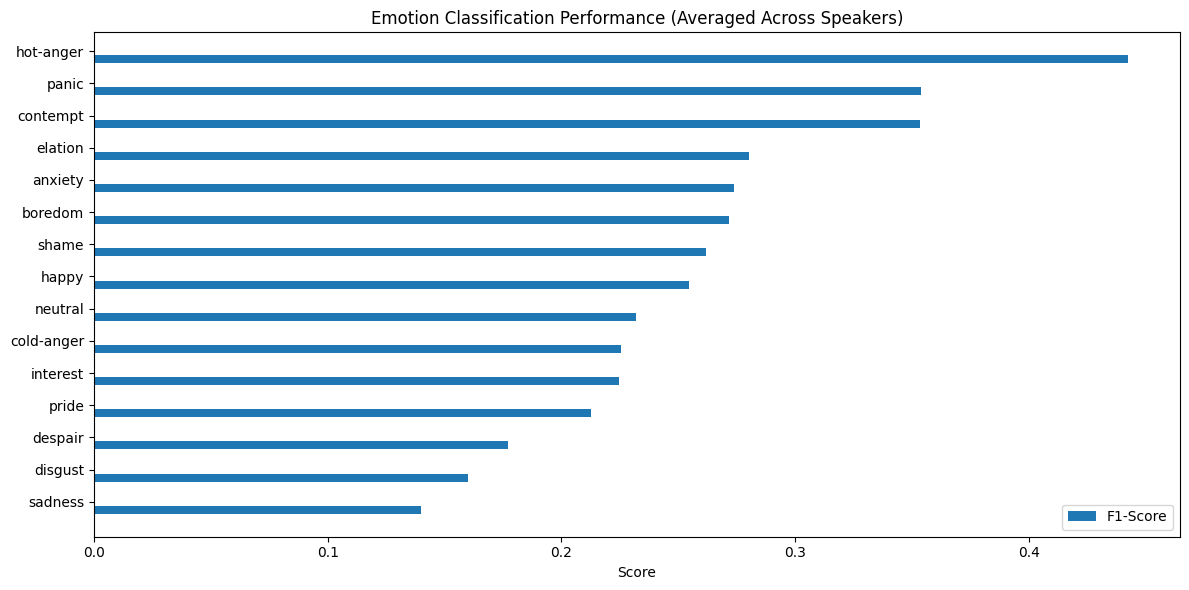

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by F1-score (already done in your code)
performance_df = performance_df.sort_values('avg_f1', ascending=True)  # Ascending for better visualization

# Set up the plot
plt.figure(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(performance_df))

# Create bars for each metric
plt.barh(index, performance_df['avg_f1'], bar_width, label='F1-Score', color='#1f77b4')

# Add labels and title
plt.yticks(index + bar_width, performance_df['emotion'])
plt.xlabel('Score')
plt.title('Emotion Classification Performance (Averaged Across Speakers)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()